In [2]:
# ! pip install botorch gpytorch


In [4]:
import numpyro
import numpy as np

In [5]:


def schwefel_1d(x):

    return 418.9829  - x * np.sin(np.sqrt(np.abs(x)))

def schwefel_nd(args):
    output = 0
    
    for dim in range(args):
        output += schwefel_1d(args[dim])

def add_gaussian_noise(signal, noise_level):

    return signal + np.random.normal(0, noise_level, 1)[0]

def schwefel_1d_with_noise(x, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_1d(x)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value

def schwefel_nd_with_noise(args, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_nd(args)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value




In [52]:

def create_data(seed, n_init, noise_level):

    np.random.seed(seed)
    X_bounds = np.array([-500,  500])
    X = np.random.uniform(X_bounds[0], X_bounds[1], size=( n_init,))
    X = np.append(X, X_bounds)
    X = np.sort(X)
    y = schwefel_1d_with_noise(X, noise_level = noise_level)

    X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
    ground_truth = schwefel_1d_with_noise(X_unmeasured, noise_level = 0)
    
    return X.reshape(-1,1), y.reshape(-1,1), X_unmeasured.reshape(-1,1), ground_truth.reshape(-1,1)


In [82]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

def step(X_measured, y_measured, X_unmeasured):
    # Convert data to tensors
    
    
    # Initialize GP model
#     print(X_measured.shape, y_measured.unsqueeze(-1).shape)
    gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
    
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)
    
    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(torch.tensor(X_unmeasured))
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()
    
    # Compute acquisition function (Expected Improvement here)
    EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
    acq_values = EI(X_unmeasured.unsqueeze(-2))
    
    return acq_values, (y_pred, y_sampled)


In [104]:
# import numpy as np

# def run_gp(num_steps, X, y, X_unmeasured, ground_truth, schwefel_1d_with_noise, noise_level):
#     X = torch.tensor(X)
#     y = torch.tensor(y)
#     X_unmeasured = torch.tensor(X_unmeasured)
#     ground_truth = torch.tensor(ground_truth)
    
#     for e in range(num_steps):
#         print(f"\nStep {e+1}/{num_steps}")
#         # Compute acquisition function and get predictions
#         acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
        
#         # Get the next point to evaluate
#         idx = acq.argmax()  # Use argmax since EI maximizes the acquisition
#         next_point = X_unmeasured[idx]
        
#         # Measure the point
#         next_point_value = schwefel_1d_with_noise(next_point.numpy(), noise_level)
        
#         # Update measured data
#         X = torch.cat([X, next_point.unsqueeze(0)], dim=0)
#         y = torch.cat([y, torch.tensor([next_point_value], dtype=torch.float)], dim=0)
    
#     # Calculate metrics after the loop
#     mse = torch.mean((y_pred - ground_truth) ** 2).item()
#     average_uncertainty = torch.mean(y_sampled).item()
    
#     return mse, average_uncertainty
import torch
import numpy as np

def standardize_data(data):
    """Standardize data to have mean=0 and std=1."""
    mean = torch.mean(data, dim=0, keepdim=True)
    std = torch.std(data, dim=0, keepdim=True)
    return (data - mean) / std


def run_gp(num_steps, X, y, X_unmeasured, ground_truth, schwefel_1d_with_noise, noise_level):
    # Convert to tensors and standardize
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X_unmeasured = torch.tensor(X_unmeasured, dtype=torch.float32)
    ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
    
    # Standardize features and target
    X = standardize_data(X)
    X_unmeasured = standardize_data(X_unmeasured)
    y= standardize_data(y)
    ground_truth = standardize_data(ground_truth)
    for e in range(num_steps):
        print(f"\nStep {e+1}/{num_steps}")
        # Compute acquisition function and get predictions
        acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
        
        # Rest of your loop...

    # Calculate metrics after the loop
    mse = torch.mean((y_pred - ground_truth) ** 2).item()
    average_uncertainty = torch.mean(y_sampled).item()
    
    return mse, average_uncertainty


In [105]:
import itertools
import pandas as pd

def grid_search(seeds, n_inits, noise_levels):
    results = []  # Initialize an empty list to store results

    # Iterate over all combinations of seeds, n_inits, and noise_levels
    for seed, n_init, noise_level in itertools.product(seeds, n_inits, noise_levels):
        print(f"Seed: {seed}, n_init: {n_init}, Noise Level: {noise_level}")
        
        # Create data for the current combination
        X, y, X_unmeasured, ground_truth = create_data(seed, n_init, noise_level)
        print(X.shape)  # Should be [n, d] where d is the number of dimensions/features
        print(y.shape) 
        # Run Gaussian Process (GP) optimization/modeling for the current combination
        mse, average_uncertainty = run_gp(5, X, y, X_unmeasured, ground_truth, schwefel_1d_with_noise, noise_level)
        print(mse)
        # Collect the results
        results.append({
            "Seed": seed,
            "n_init": n_init,
            "Noise_Level": noise_level,
            "MSE": mse,
            "Average_Uncertainty": average_uncertainty
        })

    # Convert the results to a pandas DataFrame for easy analysis and reporting
    results_df = pd.DataFrame(results)
    
    return results_df




In [107]:
# Define your parameter space
seeds = [1, 2, 3]
n_inits = [5, 10, 15, 20, 25]
noise_levels = [0, 0.01, 0.1, 0.5]

# Assuming create_data and run_gp functions are defined elsewhere

# Run the grid search
results_df = grid_search(seeds, n_inits, noise_levels)

# Display the results DataFrame
print(results_df)

Seed: 1, n_init: 5, Noise Level: 0
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 3/5

Step 4/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.4834703207015991
Seed: 1, n_init: 5, Noise Level: 0.01
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.471142292022705
Seed: 1, n_init: 5, Noise Level: 0.1
(7, 1)
(7, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are

1.4834703207015991
Seed: 1, n_init: 5, Noise Level: 0.5
(7, 1)
(7, 1)

Step 1/5

Step 2/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.490060567855835
Seed: 1, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.4958250522613525
Seed: 1, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.4987499713897705
Seed: 1, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.4684855937957764
Seed: 1, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.4980649948120117
Seed: 1, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

3.0959746837615967
Seed: 1, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.8582366704940796
Seed: 1, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 2/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 3/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to n


Step 4/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are


Step 5/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are

1.8659234046936035
Seed: 1, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.850039005279541
Seed: 1, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.9220656156539917
Seed: 1, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5
1.7824245691299438
Seed: 1, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.952939510345459
Seed: 1, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.9188467264175415
Seed: 1, n_init: 25, Noise Level: 0
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.348071575164795
Seed: 1, n_init: 25, Noise Level: 0.01
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.3391432762145996
Seed: 1, n_init: 25, Noise Level: 0.1
(27, 1)
(27, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.3390276432037354
Seed: 1, n_init: 25, Noise Level: 0.5
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.3398637771606445
Seed: 2, n_init: 5, Noise Level: 0
(7, 1)
(7, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.0889959335327148
Seed: 2, n_init: 5, Noise Level: 0.01
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.0889965295791626
Seed: 2, n_init: 5, Noise Level: 0.1
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.0889968872070312
Seed: 2, n_init: 5, Noise Level: 0.5
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.0889971256256104
Seed: 2, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.6680113077163696
Seed: 2, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.6696722507476807
Seed: 2, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.6700429916381836
Seed: 2, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.6719379425048828
Seed: 2, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.7897077798843384
Seed: 2, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.7927340269088745
Seed: 2, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.7925740480422974
Seed: 2, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.7896960973739624
Seed: 2, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5
2.1042706966400146
Seed: 2, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.103878974914551
Seed: 2, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5
2.104372262954712
Seed: 2, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.103878974914551
Seed: 2, n_init: 25, Noise Level: 0
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.1595683097839355
Seed: 2, n_init: 25, Noise Level: 0.01
(27, 1)
(27, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.1565327644348145
Seed: 2, n_init: 25, Noise Level: 0.1
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD

2.161508798599243
Seed: 2, n_init: 25, Noise Level: 0.5
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.159533977508545
Seed: 3, n_init: 5, Noise Level: 0
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.6003402471542358
Seed: 3, n_init: 5, Noise Level: 0.01
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.60093355178833
Seed: 3, n_init: 5, Noise Level: 0.1
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are

1.6003402471542358
Seed: 3, n_init: 5, Noise Level: 0.5
(7, 1)
(7, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.6003451347351074
Seed: 3, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.451256275177002
Seed: 3, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.4498707056045532
Seed: 3, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.4499812126159668
Seed: 3, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.449458360671997
Seed: 3, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.7906279563903809
Seed: 3, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
1.7892225980758667
Seed: 3, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.7892377376556396
Seed: 3, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

1.789238691329956
Seed: 3, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.0686287879943848
Seed: 3, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.053746223449707
Seed: 3, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.0540030002593994
Seed: 3, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.0544493198394775
Seed: 3, n_init: 25, Noise Level: 0
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5

Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.0695652961730957
Seed: 3, n_init: 25, Noise Level: 0.01
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 5/5
2.0689313411712646
Seed: 3, n_init: 25, Noise Level: 0.1
(27, 1)
(27, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=t

2.0327603816986084
Seed: 3, n_init: 25, Noise Level: 0.5
(27, 1)
(27, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputD


Step 4/5

Step 5/5
2.0699245929718018
    Seed  n_init  Noise_Level       MSE  Average_Uncertainty
0      1       5         0.00  1.483470             0.533026
1      1       5         0.01  1.471142             0.559593
2      1       5         0.10  1.483470             0.533026
3      1       5         0.50  1.490061             0.552982
4      1      10         0.00  1.495825             0.691920
5      1      10         0.01  1.498750             0.697778
6      1      10         0.10  1.468486             0.678819
7      1      10         0.50  1.498065             0.701203
8      1      15         0.00  3.095975             0.546266
9      1      15         0.01  1.858237             0.474034
10     1      15         0.10  1.865923             0.469591
11     1      15         0.50  1.850039             0.471573
12     1      20         0.00  1.922066             0.307850
13     1      20         0.01  1.782425             0.365753
14     1      20         0.10  1.952940       

In [108]:
results_df.to_csv('grid_search_results_botorch_v3_normalized.csv', index=False)

In [109]:
results_df

,Seed,n_init,Noise_Level,MSE,Average_Uncertainty
0,1,5,0.00,1.483470,0.533026
1,1,5,0.01,1.471142,0.559593
2,1,5,0.10,1.483470,0.533026
3,1,5,0.50,1.490061,0.552982
4,1,10,0.00,1.495825,0.691920
5,1,10,0.01,1.498750,0.697778
6,1,10,0.10,1.468486,0.678819
7,1,10,0.50,1.498065,0.701203
8,1,15,0.00,3.095975,0.546266
9,1,15,0.01,1.858237,0.474034


In [87]:
results_df

,Seed,n_init,Noise_Level,MSE,Average_Uncertainty
0,1,10,0.00,42108.119088,17.544797
1,1,10,0.01,40813.529530,15.307410
2,1,10,0.10,37841.945077,15.802484
3,1,10,0.50,37550.871366,3.830761
4,1,15,0.00,38389.632000,14.470949
5,1,15,0.01,38349.540837,12.016277
6,1,15,0.10,37489.492780,11.868182
7,1,15,0.50,38289.508883,3.746136
8,1,20,0.00,40191.983264,3.811547
9,1,20,0.01,37858.782132,22.654309


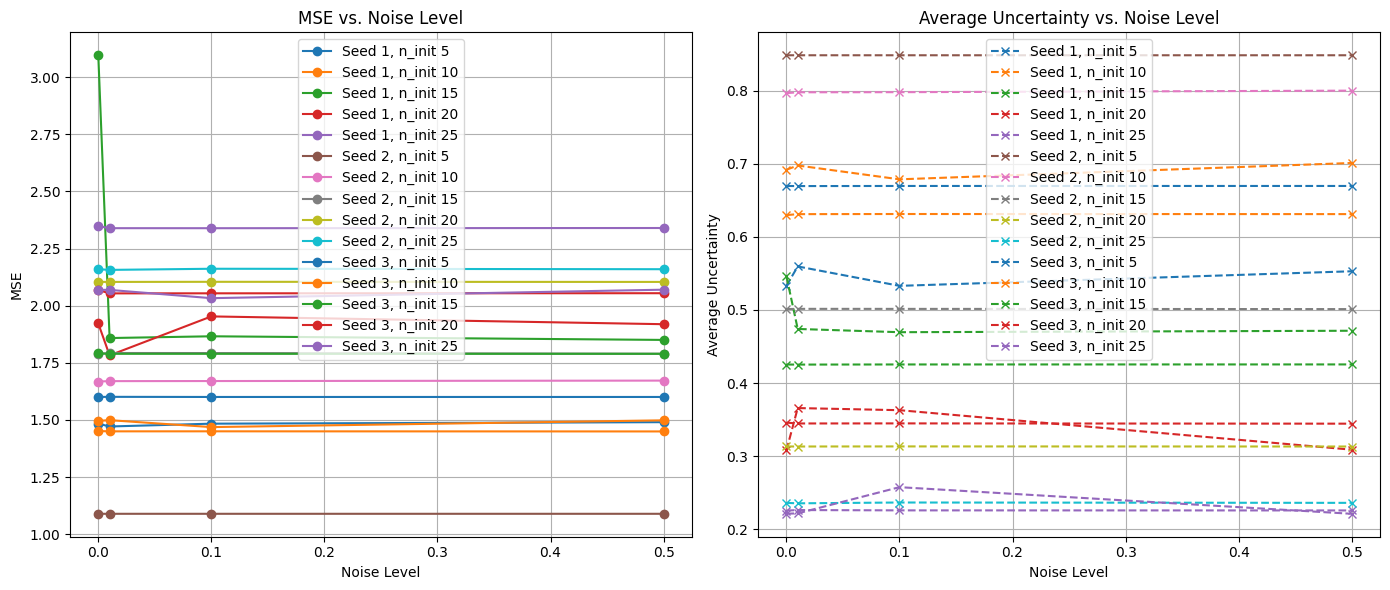

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of dictionaries into a DataFrame for easier manipulation
df = results_df

# Plot settings
plt.figure(figsize=(14, 6))

# Plot 1: MSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
for key, grp in df.groupby(['Seed', 'n_init']):
    plt.plot(grp['Noise_Level'], grp['MSE'], marker='o', linestyle='-', label=f'Seed {key[0]}, n_init {key[1]}')
plt.title('MSE vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Plot 2: Average Uncertainty
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
for key, grp in df.groupby(['Seed', 'n_init']):
    plt.plot(grp['Noise_Level'], grp['Average_Uncertainty'], marker='x', linestyle='--', label=f'Seed {key[0]}, n_init {key[1]}')
plt.title('Average Uncertainty vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Average Uncertainty')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
